In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import time
import matplotlib.pyplot as plt

## Input Testing code:

In [3]:
# cap =  cv2.VideoCapture(0, cv2.CAP_DSHOW)     # UNCOMMENT THIS LINE FOR WINDOWS
cap =  cv2.VideoCapture(1)                     # UNCOMMENT THIS LINE FOR LINUX

ref_img = False 

while cap.isOpened():
    
    success, frame_img = cap.read()
    frame_img = cv2.rotate(frame_img, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        print('')
        break
    
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [1]:
cap =  cv2.VideoCapture(0)
ref_img_test = None
count = 0
CAPTURE_COUNT = 30

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_test is None and count == CAPTURE_COUNT:    
        ref_img_test = frame_img
        print("Reference Image Captured")
    else:
        count += 1
    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

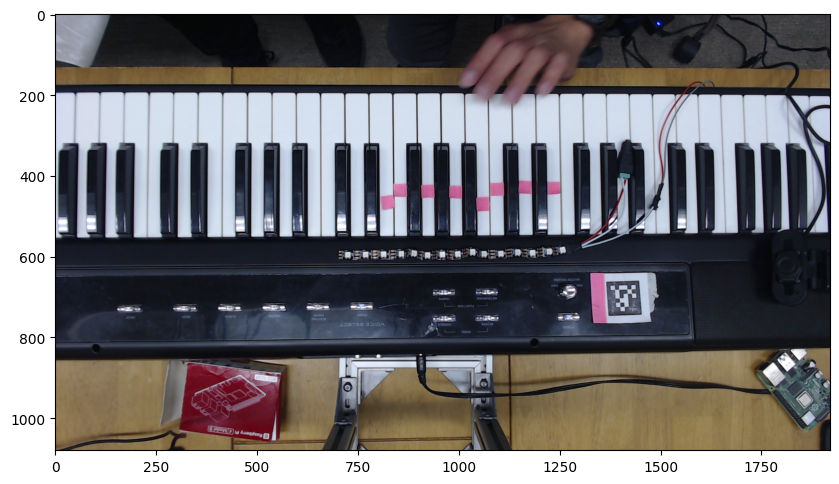

In [5]:
if ref_img_test is not None:
    ref_img_test = cv2.cvtColor(ref_img_test, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,10))
    plt.imshow(ref_img_test)
else:
    print("No reference image found")

In [6]:
ref_img_hsv = cv2.cvtColor(ref_img_test, cv2.COLOR_RGB2HSV)

## Color Picker code:

In [7]:
def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pixel = image[y, x]
        
        # Convert the BGR pixel into the HSV color space
        hsv = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        
        print("HSV Color: ", hsv)

# Load your image
image = ref_img_test
if image is None:
    print("Could not open or find the image.")
else:
    # Create a window
    cv2.namedWindow('image')
    
    # Set the mouse callback function to 'pick_color'
    cv2.setMouseCallback('image', pick_color)
    
    # Display the image
    cv2.imshow('image', image)
    
    # Wait until a key is pressed to exit
    cv2.waitKey(0)
    cv2.destroyAllWindows()

HSV Color:  [ 16  33 236]
HSV Color:  [ 16  33 236]
HSV Color:  [ 16  33 236]
HSV Color:  [135 124 203]


## Clustering as Numpy Arrays

In [3]:
def apply_threshold_hsv(roi, hsv_color, threshold_h=10, threshold_s=35, threshold_v=80):
    """Apply color thresholding in HSV color space to isolate specific color ranges in the ROI."""
    
    lower_bound = np.array([max(0, hsv_color[0] - threshold_h), max(0, hsv_color[1] - threshold_s), max(0, hsv_color[2] - threshold_v)])
    upper_bound = np.array([min(180, hsv_color[0] + threshold_h), min(255, hsv_color[1] + threshold_s), min(255, hsv_color[2] + threshold_v)])
    mask = cv2.inRange(roi, lower_bound, upper_bound)
    return mask


def find_clusters(ref_img_hsv, hsv_color=(174, 131, 201), eps=10, min_size_threshold=90, max_size_threshold=300):
    """
    Find clusters of points in an image based on a given HSV color.

    Parameters:
    - ref_img_hsv (numpy.ndarray): The input image in HSV color space.
    - hsv_color (tuple): The target HSV color to find clusters around. Default is (174, 131, 201).
    - min_size_threshold (int): The minimum size threshold for a cluster to be considered. Default is 10.
    - max_size_threshold (int): The maximum size threshold for a cluster to be considered. Default is 300.

    Returns:
    - numpy.ndarray: An array of filtered clusters, where each cluster is represented as an array of points.

    Note:
    - The input image should be in HSV color space.
    - The returned clusters are filtered based on their size, where the size is determined by the number of points in the cluster.
    """
    
    mask = apply_threshold_hsv(ref_img_hsv, hsv_color)
    
    y_coord, x_coord = np.where(mask != 0)
    if len(y_coord) == 0:
        return np.array([])  # Return an empty numpy array if no points found
    
    coord_array = np.stack((x_coord, y_coord), axis=-1)
    dbscan = DBSCAN(eps=eps, min_samples=min_size_threshold)
    clusters = dbscan.fit_predict(coord_array)

    # Filter clusters based on size
    filtered_cluster_list = []
    for cluster_idx in np.unique(clusters):
        if cluster_idx != -1:
            cluster_points = coord_array[clusters == cluster_idx]
            if min_size_threshold <= len(cluster_points) <= max_size_threshold:
                filtered_cluster_list.append(cluster_points)
    return np.array(filtered_cluster_list, dtype=object)


def arrange_clusters(filtered_cluster_list):
    """
    Arrange clusters from left to right based on their mean x-coordinate.
    
    Parameters:
    - filtered_cluster_list: numpy.ndarray
        An array of filtered clusters, where each cluster is represented by an array of points.
        
    Returns:
    - numpy.ndarray
        An array of clusters sorted from left to right.
    """
    if len(filtered_cluster_list) == 0:
        return filtered_cluster_list  # Return the empty array if no clusters

    # Calculate the mean x-coordinate for each cluster
    mean_x_coords = [np.mean(cluster[:, 0]) for cluster in filtered_cluster_list]
    
    # Sort the clusters based on their mean x-coordinate
    sorted_indices = np.argsort(mean_x_coords)
    
    # Reorder the clusters based on the sorted indices
    sorted_clusters = filtered_cluster_list[sorted_indices]

    return sorted_clusters

### Finding optimal epsilon for DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_eps(image, hsv_color, min_samples):
    """
    Finds the optimal eps value for DBSCAN by plotting the k-nearest neighbors distances.
    
    Parameters:
    - data (numpy.ndarray): The dataset to cluster.
    - min_samples (int): The min_samples parameter for DBSCAN to determine k for k-nearest neighbors.
    """
    mask = apply_threshold_hsv(image, hsv_color)
    
    y_coord, x_coord = np.where(mask != 0)
    if len(y_coord) == 0:
        return np.array([])  # Return an empty numpy array if no points found
    
    coord_array = np.stack((x_coord, y_coord), axis=-1)
    
    # Compute the nearest neighbor distances
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(coord_array)
    distances, indices = neigh.kneighbors(coord_array)
    
    # Sort the distances
    sorted_distances = np.sort(distances[:, min_samples-1], axis=0)
    
    # Plot the k-distance graph
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_distances)
    plt.title('k-distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {min_samples}th nearest neighbor')
    plt.grid(True)
    plt.show()

median_filtered_img = cv2.medianBlur(ref_img_hsv, 3)
min_samples = 80
hsv_color=(160,117,189)
find_optimal_eps(median_filtered_img, hsv_color, min_samples=min_samples)

### VISUALIZATION

In [ ]:
import matplotlib.patches as patches

def plot_clusters_on_image(clusters):
    """
    Plot an image and draw green bounding boxes with labels over the clusters.
    """
    tmp = ref_img_test.copy()
    
    for cluster in clusters:
        x, y, w, h = cv2.boundingRect(cluster)
        print(x, y, w, h)
        cv2.rectangle(tmp, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    plt.figure(figsize=(10,10))
    plt.imshow(tmp)
    plt.show()

color = (174, 131, 201)
# color = (160,117,189)
clusters = find_clusters(ref_img_hsv, hsv_color=color, eps=6, min_size_threshold=60, max_size_threshold=200)
print(len(clusters))
clusters = arrange_clusters(clusters)
if len(clusters) > 0:
    plot_clusters_on_image(clusters)


## Centroid Calculation & Visualization

In [4]:
def calculate_centroids(filtered_cluster_list):
    """
    Calculate the centroids of filtered clusters.

    Parameters:
    - filtered_cluster_list: numpy.ndarray
        An array of filtered clusters, where each cluster is represented by an array of points.
        
    Returns:
    - list
        A list of centroids of the clusters.
    """
    centroids = []
    for cluster in filtered_cluster_list:
        centroid_x = np.mean(cluster[:, 0])
        centroid_y = np.mean(cluster[:, 1])
        centroids.append((centroid_x, centroid_y))
    return centroids

In [ ]:
def plot_centroids_on_image(centroids, image):
    """
    Plot an image and draw a green dot at each centroid.
    
    Parameters:
    - centroids: list of tuples
        A list of coordinates representing the centroid of each cluster.
    - image: numpy.ndarray
        The image on which to plot the centroids.
    """
    tmp = image.copy()
    
    for idx, (cx, cy) in enumerate(centroids):
        # Draw a green dot at the centroid
        cv2.circle(tmp, (int(cx), int(cy)), 3, (0, 255, 0), -1)
        # Put the cluster index number next to the dot
        cv2.putText(tmp, str(idx), (int(cx) + 10, int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255, 255, 255), 2)
    
    plt.figure(figsize=(10,10))
    plt.imshow(tmp)
    plt.axis('off')  # Hide the axis
    plt.show()
    
plot_centroids_on_image(calculate_centroids(clusters), ref_img_test)

## PCA & Visualization

In [5]:
import numpy as np
from sklearn.decomposition import PCA

def calculate_displacements(ref_centroids, curr_centroids):
    """
    Calculate displacements of centroids from the reference frame to the current frame.
    
    Parameters:
    - ref_centroids: list of tuples
        The reference centroids from the initial frame.
    - curr_centroids: list of tuples
        The centroids from the current frame.
        
    Returns:
    - numpy.ndarray
        The displacements of centroids.
    """
    # Ensure that both centroid lists have the same number of centroids
    if len(ref_centroids) != len(curr_centroids):
        raise ValueError("The number of centroids in both frames does not match.")

    # Calculate displacements as differences in x and y coordinates
    displacements = np.array(curr_centroids) - np.array(ref_centroids)
    return displacements

def perform_pca_on_displacements(displacements):
    """
    Perform PCA on centroid displacements to isolate camera shake vs key-presses.
    
    Parameters:
    - displacements: numpy.ndarray
        The displacements of centroids.
        
    Returns:
    - numpy.ndarray
        The transformed displacements in the space of principal components.
    """
    # Initialize PCA, assuming 2 components for 2D data
    pca = PCA(n_components=2)

    # Fit PCA to the displacement data
    pca.fit(displacements)

    # Transform the data
    transformed_data = pca.transform(displacements)
    return transformed_data

def identify_key_presses(transformed_displacements, threshold):
    """
    Identify if a key was pressed based on the displacement along the principal components.
    
    Parameters:
    - transformed_displacements: numpy.ndarray
        The centroids' displacements transformed into the principal component space.
    - threshold: float
        The threshold for identifying significant displacements indicating a key press.
        
    Returns:
    - List
        List of indices of centroids with a displacement above the threshold.
    """
    key_presses = []
    for i, displacement in enumerate(transformed_displacements):
        if np.abs(displacement[1]) > threshold:  # Change to the appropriate PC if necessary
            key_presses.append(i)
    
    return key_presses


In [12]:
# cap =  cv2.VideoCapture('output.mp4')
# cap =  cv2.VideoCapture('output_no_press.mp4')
# color = (174, 131, 201)

cap =  cv2.VideoCapture('cope.mp4')
color = (160,117,189)

ref_img_hsv = None
ref_centroids = None
pca_threshold = 0.4
count = 0
CAPTURE_COUNT = 20
eps = 6
min_size_threshold = 70
max_size_threshold = 200
displacement_threshold = 10


centroid_history = {}
history_length = 10  # Number of frames to consider for smoothing

def update_centroid_history(centroid_history, new_centroids, history_length):
    for idx, new_centroid in enumerate(new_centroids):
        if idx not in centroid_history:
            # If there's no history for the centroid, create one
            centroid_history[idx] = [new_centroid] * history_length
        else:
            # Update the history and keep it to the specified length
            centroid_history[idx].append(new_centroid)
            centroid_history[idx] = centroid_history[idx][-history_length:]

def calculate_smoothed_centroids(centroid_history):
    smoothed_centroids = []
    for idx, history in centroid_history.items():
        # Calculate the mean position over the history for each centroid
        history_array = np.array(history)
        mean_centroid = np.mean(history_array, axis=0)
        smoothed_centroids.append(mean_centroid)
    return smoothed_centroids


while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    
    if not success:
        print("Ignoring empty camera frame.")
        break

    # frame_img = cv2.medianBlur(frame_img, 3)
    
    if ref_img_hsv is None and count == CAPTURE_COUNT:    
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, \
                                 hsv_color=color, \
                                 eps=eps, \
                                 min_size_threshold=min_size_threshold, \
                                 max_size_threshold=max_size_threshold)
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
        print("Captured Reference Image")
    else:
        count += 1
    
    if ref_img_hsv is not None:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, \
                                           hsv_color=color, \
                                           eps=eps, \
                                           min_size_threshold=min_size_threshold, \
                                           max_size_threshold=max_size_threshold)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)
        # Drawing original (reference) centroids in blue
        for centroid in ref_centroids:
            cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (255, 0, 0), -1)
        # Drawing current (inference) centroids in green
        # for centroid in inference_centroids:
        #     cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 255, 0), -1)
        
        # Drawing inference centroids in green if they are calculated
        if len(inference_centroids) == len(ref_centroids):
            update_centroid_history(centroid_history, inference_centroids, history_length)
            smoothed_centroids = calculate_smoothed_centroids(centroid_history)
            
            
            displacements = calculate_displacements(ref_centroids, smoothed_centroids)
            transformed_displacements = perform_pca_on_displacements(displacements)
            key_press_indices = identify_key_presses(transformed_displacements, threshold=pca_threshold)
            print('Key presses:', key_press_indices)
            
            for idx, centroid in enumerate(smoothed_centroids):
                if idx in key_press_indices:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 0, 255), -1)
                else:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 255, 0), -1)
        else:
            print("No. of centroids mismatch")
            
    time.sleep(0.01)

    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
    
cap.release()
cv2.destroyAllWindows()


Captured Reference Image
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []
Key presses: []

## Optical Flow?????

In [ ]:
import cv2
import numpy as np

cap = cv2.VideoCapture('cope.mp4')
color = (160, 117, 189)

ref_img_hsv = None
ref_clusters = None
ref_centroids = None

count = 0
CAPTURE_COUNT = 20
displacement_threshold = 5  # Lower threshold for testing
eps = 6
min_size_threshold = 70
max_size_threshold = 200

prev_gray = None
lk_params = dict(winSize=(21, 21), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 0.02))

while cap.isOpened():
    success, frame_img = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_hsv is None and count == CAPTURE_COUNT:
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, hsv_color=color, eps=eps, min_size_threshold=min_size_threshold, max_size_threshold=max_size_threshold)
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
        print("Captured Reference Image")
    else:
        count += 1

    if ref_img_hsv is not None:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, hsv_color=color, eps=eps, min_size_threshold=min_size_threshold, max_size_threshold=max_size_threshold)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)

        gray = cv2.cvtColor(frame_img, cv2.COLOR_BGR2GRAY)
        if prev_gray is not None:
            flattened_clusters = np.concatenate([cluster.reshape(-1, 2) for cluster in ref_clusters], axis=0)
            cluster_points = flattened_clusters.astype(np.float32).reshape(-1, 1, 2)
            next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, cluster_points, None, **lk_params)

            global_motion = np.median(next_points - cluster_points, axis=0)[0]
            cluster_displacements = next_points - cluster_points - global_motion

            key_press_indices = []
            for idx, (cluster, centroid, displacement) in enumerate(zip(ref_clusters, ref_centroids, cluster_displacements)):
                # No centroid smoothing
                # smoothed_centroids.append(centroid + displacement.mean(axis=0))

                # Identify keypresses based on displacement magnitude
                if np.linalg.norm(displacement.mean(axis=0)) > displacement_threshold:
                    key_press_indices.append(idx)
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 0, 255), -1)
                else:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 255, 0), -1)

            print('Key presses:', key_press_indices)

        prev_gray = gray

    cv2.imshow('Pressed Key Frame', frame_img)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

cap.release()
cv2.destroyAllWindows()

In [46]:
# Open the video capture
cap = cv2.VideoCapture('output_no_press.mp4')

# Parameters for goodFeaturesToTrack
max_corners = 100  # Maximum number of corners to detect
quality_level = 0.25  # Quality level parameter for the detector
min_distance = 20  # Minimum distance between corners

# Other parameters
feature_params = dict(maxCorners=max_corners, qualityLevel=quality_level, minDistance=min_distance, blockSize=7)

# Create a mask to exclude certain regions from feature detection
# mask = np.zeros_like(old_frame)
# mask[...] = 255  # Use mask = None if you don't want to exclude any region

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error reading frame from video stream")
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect good feature points
    corners = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)

    # Draw the detected corners on the frame
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)

    # Display the frame with the detected corners
    cv2.imshow('Good Features', frame)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close the window
cap.release()
cv2.destroyAllWindows()

/var/folders/40/z3syxft1421_ytt41ln4qfg80000gn/T/ipykernel_1105/1632481664.py:35: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)


Error reading frame from video stream


## AprilTag Displacement Normalization

In [18]:
from pupil_apriltags import Detector

# Initialize the AprilTag detector
at_detector = Detector(families='tag36h11',
                   nthreads=1,
                   quad_decimate=1.0,
                   quad_sigma=0.0,
                   refine_edges=1,
                   decode_sharpening=0.25,
                   debug=0)

In [20]:
def frame_correction(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    at_detected = False

    camera_params = [640, 480, 640, 480]  # fx, fy, cx, cy
    tag_size = 0.05  # Tag size in meters

    tags = at_detector.detect(gray, estimate_tag_pose=True, camera_params=camera_params, tag_size=tag_size)
    corners, euler_angles = [], []

    for tag in tags:
        corners = tag.corners
        at_detected = True

        # euler_angles = rotationMatrixToEulerAngles(tag.pose_R)
    return corners, euler_angles, at_detected

def get_center(coords):
    x_max = max(coords[0][0], coords[1][0], coords[2][0], coords[3][0])
    x_min = min(coords[0][0], coords[1][0], coords[2][0], coords[3][0])
    y_max = max(coords[0][1], coords[1][1], coords[2][1], coords[3][1])
    y_min = min(coords[0][1], coords[1][1], coords[2][1], coords[3][1])
    center_x = ((x_max - x_min) / 2) + x_min
    center_y = ((y_max - y_min) / 2) + y_min
    
    return (center_x, center_y)

In [23]:
# cap =  cv2.VideoCapture('output.mp4')
cap =  cv2.VideoCapture('output_no_press.mp4')
color = (174, 131, 201)

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    corners, _, detected = frame_correction(frame_img)
    if detected:
        for idx in range(len(corners)):
            cv2.line(frame_img, tuple(corners[idx - 1].astype(int)), tuple(corners[idx].astype(int)), (0, 255, 0), 2)
            
        tag_centroid = calculate_centroids([corners])
        tx, ty = tag_centroid[0]
        cv2.circle(frame_img, (int(tx), int(ty)), 3, (0, 255, 0), -1)
        

    
    cv2.imshow('Pressed Key Frame', frame_img)
    time.sleep(0.01)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
    
cap.release()
cv2.destroyAllWindows()

Ignoring empty camera frame.


In [ ]:
# cap =  cv2.VideoCapture('output.mp4')
# cap =  cv2.VideoCapture('output_no_press.mp4')
# color = (174, 131, 201)

cap =  cv2.VideoCapture('cope.mp4')
color = (160,117,189)

ref_img_hsv = None
ref_centroids = None
ref_tag_centroid = None
pca_threshold = 0.6
count = 0
CAPTURE_COUNT = 20
eps = 6
min_size_threshold = 70
max_size_threshold = 200
displacement_threshold = 10


while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    
    if not success:
        print("Ignoring empty camera frame.")
        break

    # frame_img = cv2.medianBlur(frame_img, 3)
    if count < CAPTURE_COUNT:
        count += 1
        continue
    
    if ref_img_hsv is None or ref_tag_centroid is None:    
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, \
                                 hsv_color=color, \
                                 eps=eps, \
                                 min_size_threshold=min_size_threshold, \
                                 max_size_threshold=max_size_threshold)
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
        print("Captured Reference Image")
        corners, _, detected = frame_correction(frame_img)
        if detected:
            ref_tag_centroid = calculate_centroids([corners])
    
    if ref_img_hsv is not None:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, \
                                           hsv_color=color, \
                                           eps=eps, \
                                           min_size_threshold=min_size_threshold, \
                                           max_size_threshold=max_size_threshold)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)
        
        # Drawing original (reference) centroids in blue
        for centroid in ref_centroids:
            cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (255, 0, 0), -1)\
        
        # Drawing inference centroids in green if they are calculated
        if len(inference_centroids) == len(ref_centroids):
            tag_displacement = [0,0]
            corners, _, detected = frame_correction(frame_img)
            if detected:
                for idx in range(len(corners)):
                    cv2.line(frame_img, tuple(corners[idx - 1].astype(int)), tuple(corners[idx].astype(int)), (0, 255, 0), 2)
                    
                tag_centroid = calculate_centroids([corners])
                tx, ty = tag_centroid[0]
                cv2.circle(frame_img, (int(tx), int(ty)), 3, (0, 255, 0), -1)
                tag_displacement = calculate_displacements(ref_tag_centroid, tag_centroid)
                tag_displacement = tag_displacement[0]
            
            for i in range(len(displacements)):
                displacements[i][0] -= tag_displacement[0]
                displacements[i][1] -= tag_displacement[0]
            displacements = calculate_displacements(ref_centroids, inference_centroids)
            transformed_displacements = perform_pca_on_displacements(displacements)
            key_press_indices = identify_key_presses(transformed_displacements, threshold=pca_threshold)
            print('Key presses:', key_press_indices)
            
            for idx, centroid in enumerate(inference_centroids):
                if idx in key_press_indices:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 0, 255), -1)
                else:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 255, 0), -1)
        else:
            print("No. of centroids mismatch")
            
    time.sleep(0.01)

    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
    
cap.release()
cv2.destroyAllWindows()


## Isolating y-displacements

In [10]:
# cap =  cv2.VideoCapture('output.mp4')
# cap =  cv2.VideoCapture('output_no_press.mp4')
# color = (174, 131, 201)

# cap =  cv2.VideoCapture('cope.mp4')
color = (160,117,189)

cap = cv2.VideoCapture(0)

ref_img_hsv = None
ref_centroids = None
count = 0
CAPTURE_COUNT = 20
eps = 6
min_size_threshold = 70
max_size_threshold = 200
displacement_threshold = 0.6


while cap.isOpened():
    
    success, frame_img = cap.read()
    frame_img = cv2.rotate(frame_img, cv2.ROTATE_180)

    
    if not success:
        print("Ignoring empty camera frame.")
        break

    # frame_img = cv2.medianBlur(frame_img, 3)
    if count < CAPTURE_COUNT:
        count += 1
        continue
    
    if ref_img_hsv is None:    
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, \
                                 hsv_color=color, \
                                 eps=eps, \
                                 min_size_threshold=min_size_threshold, \
                                 max_size_threshold=max_size_threshold)
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
        print("Captured Reference Image")
    
    if ref_img_hsv is not None:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, \
                                           hsv_color=color, \
                                           eps=eps, \
                                           min_size_threshold=min_size_threshold, \
                                           max_size_threshold=max_size_threshold)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)
        
        # Drawing original (reference) centroids in blue
        for centroid in ref_centroids:
            cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (255, 0, 0), -1)\
        
        if len(inference_centroids) == len(ref_centroids):
            displacements = calculate_displacements(ref_centroids, inference_centroids)
            mean_x_dis = np.mean(displacements[:, 0])
            mean_y_dis = np.mean(displacements[:, 1])
            normalized = []
            for ix, iy in inference_centroids:
                normalized.append((ix-mean_x_dis , iy-mean_y_dis))
            
            displacements[:, 0] -= mean_x_dis
            displacements[:, 1] -= mean_y_dis
            
            key_press_indices = []
            for idx, dy in enumerate(displacements[:,1]):
                if dy > displacement_threshold:
                    key_press_indices.append(idx)
            
            print('Key presses:', key_press_indices)
            
            for idx, centroid in enumerate(normalized):
                if idx in key_press_indices:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 0, 255), -1)
                else:
                    cv2.circle(frame_img, (int(centroid[0]), int(centroid[1])), 3, (0, 255, 0), -1)
        else:
            print("No. of centroids mismatch")
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
    
cap.release()
cv2.destroyAllWindows()


Captured Reference Image
